In [1]:
import numpy as np
import os
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array

In [2]:
train_dir = Path('skin diseases/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))
test_dir = Path('skin diseases/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))
val_dir = Path('skin diseases/valid')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [3]:
def image_processing(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [4]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [5]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 7012

Number of different labels: 12

Labels: ['squamous cell carcinoma' 'atopic' 'bcc' 'basal cell carcinoma'
 'vascular lesion' 'pigmented benign keratosis' 'melanoma' 'acne'
 'actinic keratosis' 'nevus' 'seborrheic keratosis' 'dermatofibroma']


In [6]:
train_df.head(5)

,Filepath,Label
0,skin diseases/train/squamous cell carcinoma/IS...,squamous cell carcinoma
1,skin diseases/train/atopic/126_6_18_jpg.rf.89a...,atopic
2,skin diseases/train/bcc/598_jpg.rf.fed3f9869c8...,bcc
3,skin diseases/train/basal cell carcinoma/ISIC_...,basal cell carcinoma
4,skin diseases/train/bcc/505_jpg.rf.cf435a4012d...,bcc


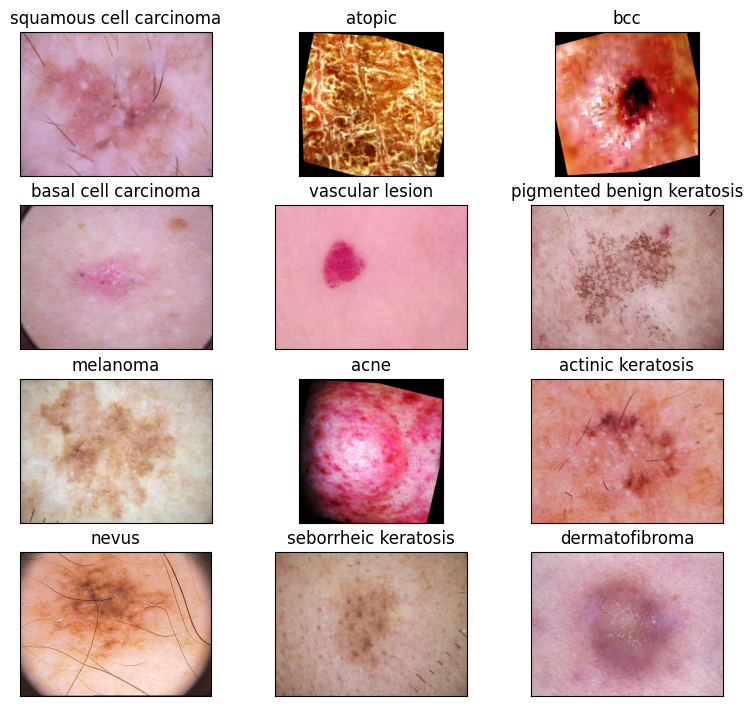

In [7]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [8]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input
)

In [9]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 7012 validated image filenames belonging to 12 classes.


In [10]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 323 validated image filenames belonging to 12 classes.


In [11]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 323 validated image filenames belonging to 12 classes.


In [12]:
pretrained_model = tf.keras.applications.VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [13]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(12, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=train_images,
    batch_size = 32,
    epochs=10, #5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


220/220 ━━━━━━━━━━━━━━━━━━━━ 2014s 9s/step - accuracy: 0.5120 - loss: 1.4831 - val_accuracy: 0.6964 - val_loss: 0.8108
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 1802s 8s/step - accuracy: 0.7047 - loss: 0.7709 - val_accuracy: 0.7647 - val_loss: 0.6283
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 1650s 8s/step - accuracy: 0.7530 - loss: 0.6431 - val_accuracy: 0.8180 - val_loss: 0.5070
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 1332s 6s/step - accuracy: 0.7964 - loss: 0.5442 - val_accuracy: 0.8473 - val_loss: 0.4338
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 1053s 5s/step - accuracy: 0.8343 - loss: 0.4622 - val_accuracy: 0.8517 - val_loss: 0.3971
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 1037s 5s/step - accuracy: 0.8533 - loss: 0.3823 - val_accuracy: 0.8815 - val_loss: 0.3358
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 1000s 5s/step - accuracy: 0.8770 - loss: 0.3261 - val_accuracy: 0.8982 - val_loss: 0.2910
Epoch 8/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 1012s 5s/step - accuracy: 0.8835 - loss: 0.3034 - val_accurac

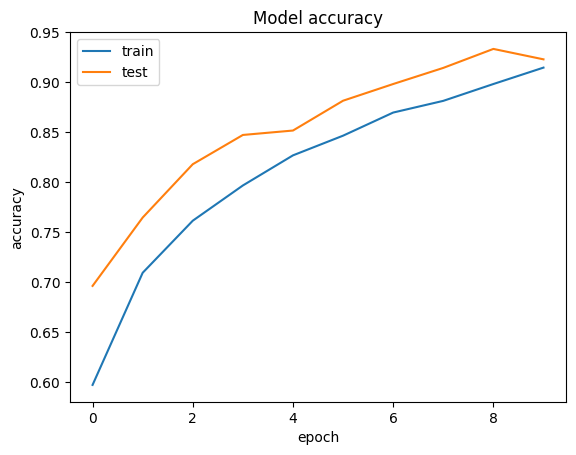

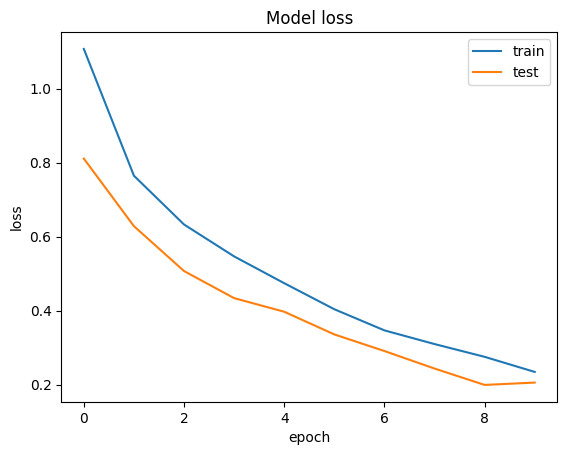

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'])

plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'])

plt.show()

In [15]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

11/11 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step


['acne',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'bcc',
 'bcc',
 'acne',
 'melanoma',
 'acne',
 'acne',
 'acne',
 'actinic keratosis',
 'atopic',
 'basal cell carcinoma',
 'bcc',
 'melanoma',
 'acne',
 'acne',
 'atopic',
 'melanoma',
 'nevus',
 'nevus',
 'melanoma',
 'nevus',
 'atopic',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'nevus',
 'atopic',
 'atopic',
 'basal cell carcinoma',
 'bcc',
 'acne',
 'acne',
 'pigmented benign keratosis',
 'pigmented benign keratosis',
 'melanoma',
 'squamous cell carcinoma',
 'dermatofibroma',
 'atopic',
 'nevus',
 'nevus',
 'bcc',
 'nevus',
 'acne',
 'seborrheic keratosis',
 'basal cell carcinoma',
 'melanoma',
 'vascular lesion',
 'bcc',
 'bcc',
 'squamous cell carcinoma',
 'basal cell carcinoma',
 'bcc',
 'bcc',
 'melanoma',
 'atopic',
 'pigmented benign keratosis',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'pigmented benign keratosis',
 'atopic',
 'atopic',
 'nevus',
 'nevus',
 'bcc',
 'nevus',
 'pigmented benign

In [16]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [21]:
from sklearn.metrics import recall_score, precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np

labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())

pred2 = [labels[k] for k in pred] 
y_test = [labels[k] for k in test_images.classes]
print(y_test)
from sklearn.metrics import accuracy_score
recall = recall_score(y_test, pred2,average='macro',zero_division=1)
precision = precision_score(y_test, pred2,average='macro',zero_division=1)

print(f'Recall score: {100*recall:.2f}%')
print(f'Precision score: {100*precision:.2f}%')

['atopic', 'squamous cell carcinoma', 'dermatofibroma', 'bcc', 'bcc', 'bcc', 'acne', 'acne', 'acne', 'acne', 'acne', 'atopic', 'bcc', 'bcc', 'atopic', 'acne', 'acne', 'atopic', 'squamous cell carcinoma', 'acne', 'nevus', 'seborrheic keratosis', 'melanoma', 'atopic', 'atopic', 'bcc', 'nevus', 'atopic', 'acne', 'acne', 'bcc', 'acne', 'atopic', 'atopic', 'pigmented benign keratosis', 'dermatofibroma', 'actinic keratosis', 'dermatofibroma', 'bcc', 'acne', 'nevus', 'bcc', 'melanoma', 'atopic', 'basal cell carcinoma', 'acne', 'atopic', 'acne', 'bcc', 'atopic', 'squamous cell carcinoma', 'basal cell carcinoma', 'bcc', 'bcc', 'seborrheic keratosis', 'bcc', 'dermatofibroma', 'acne', 'squamous cell carcinoma', 'atopic', 'atopic', 'atopic', 'acne', 'pigmented benign keratosis', 'bcc', 'atopic', 'actinic keratosis', 'bcc', 'atopic', 'atopic', 'actinic keratosis', 'melanoma', 'squamous cell carcinoma', 'dermatofibroma', 'atopic', 'acne', 'atopic', 'pigmented benign keratosis', 'acne', 'pigmented be

Confusion Matrix:
[[30  2  8  7  4  0  6  4  2  4  0  1]
 [ 0  0  0  0  0  0  0 12  3  0  1  0]
 [13  0 30  0  8  0  6  4  3  1  0  2]
 [ 0  0  0 12  0  0  0  0  3  1  0  0]
 [ 1  0  3  2 49  0 13  1  0  1  0  0]
 [ 0  0  0  3  0  6  2  2  1  0  0  2]
 [ 0  0  1  0  1  0  2 11  1  0  0  0]
 [ 0  0  0  0  0  0  0 16  0  0  0  0]
 [ 0  0  0  2  0  1  0  1 11  0  1  0]
 [ 0  0  0  0  0  0  3  0  0  0  0  0]
 [ 0  0  0  7  0  0  1  1  2  0  5  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  3]]


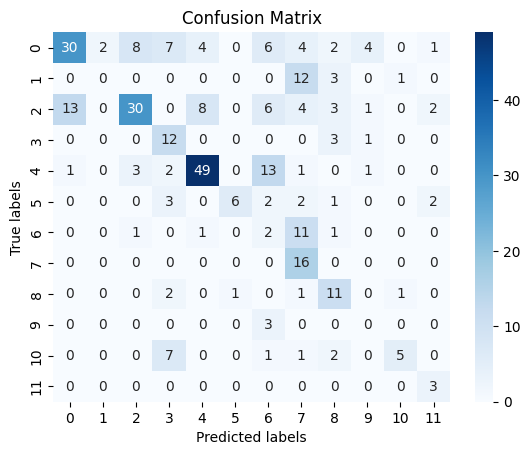

In [18]:
cm = confusion_matrix(y_test, pred2)
# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# If you want to visualize the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create a heatmap
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()